# Parallelizing the RAAR Experiment with CUDA

This notebook summarizes the work done to parallelize the Relaxed Averaged Alternating Reflection (RAAR) algorithm using CUDA for GPU acceleration.

## 1. Introduction

The RAAR algorithm is used in phase retrieval problems, particularly in Coherent Diffraction Imaging (CDI). We've parallelized this algorithm to leverage GPU acceleration using CUDA and CuPy.

## 2. Key Components

### 2.1 RAAR_Cuda Class

The `RAAR_Cuda` class is the GPU-accelerated version of the RAAR algorithm.


In [2]:
from proxtoolbox.algorithms.algorithm import Algorithm
from proxtoolbox.utils.cell import Cell, isCell
from cupy import exp  # Replace NumPy exp with CuPy exp

class RAAR_Cuda(Algorithm):
    """
    GPU-accelerated version of the Relaxed Averaged Alternating
    Reflection algorithm using CuPy.
    """

    def evaluate(self, u):
        """
        Update for the Relaxed Averaged Alternating
        Reflection algorithm using GPU acceleration.
        """
        lmbd = self.computeRelaxation()
        
        # Assuming `u` is now a CuPy array or list of CuPy arrays
        if not isinstance(u, list):
            # Reflection using prox2 on u
            tmp1 = 2 * self.prox2.eval(u) - u  
            # Projection of the reflection
            tmp2 = self.prox1.eval(tmp1)
            # Update
            u_new = (lmbd * (2 * tmp2 - tmp1) + (1 - lmbd) * tmp1 + u) / 2
        else:
            # If `u` is a list of CuPy arrays
            u_new = [self.prox2.eval(ui) for ui in u]
            tmp1 = [2 * u_new[j] - u[j] for j in range(len(u))]
            tmp2 = [self.prox1.eval(tmp1[j]) for j in range(len(tmp1))]
            # Update for each element in the list
            for j in range(len(u)):
                u_new[j] = (lmbd * (2 * tmp2[j] - tmp1[j]) + (1 - lmbd) * tmp1[j] + u[j]) / 2
        
        return u_new

    def getDescription(self):
        return self.getDescriptionHelper("\\lambda", self.lambda_0, self.lambda_max)



### 2.2 SIRIUS_CDI_Experiment_Cuda Class

This class represents the CUDA-accelerated version of the SIRIUS CDI experiment.


In [3]:
class SIRIUS_CDI_Experiment_Cuda(PhaseExperiment):
    def loadData(self):
        # Load and preprocess data using CuPy
        f = cp.load(datadir / 'Phase' / 'diff2D_2_2796_2796.npy')
        dp = f[0, :, :]
        # ... (data preprocessing)
    def setupProxOperators(self):
        self.proxOperators = ['P_Sparse_support_cuda']
        self.propagator = 'Propagator_FreFra'
        self.inverse_propagator = 'InvPropagator_FreFra'
        self.proxOperators.append('Approx_Pphase_FreFra_Poisson_cuda')
        self.nProx = self.sets

NameError: name 'PhaseExperiment' is not defined


## 3. Key Changes for GPU Acceleration

1. Replaced NumPy with CuPy for array operations
2. Used CUDA-specific proximal operators (e.g., `P_Sparse_support_cuda`)
3. Implemented CUDA versions of utility functions (e.g., `CudaCell`)

## 4. Example Usage

Here's how to run the CUDA-accelerated SIRIUS CDI experiment:


In [1]:
!nvidia-smi 

Sat Sep 14 22:14:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4500               Off | 00000000:01:00.0 Off |                  Off |
| 30%   32C    P8              16W / 200W |     20MiB / 20470MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 6000 iterations and 9.337231636047363 seconds.


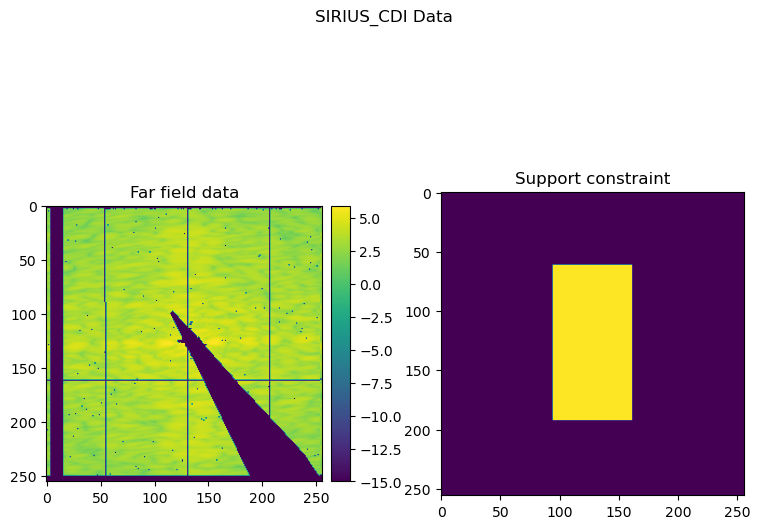

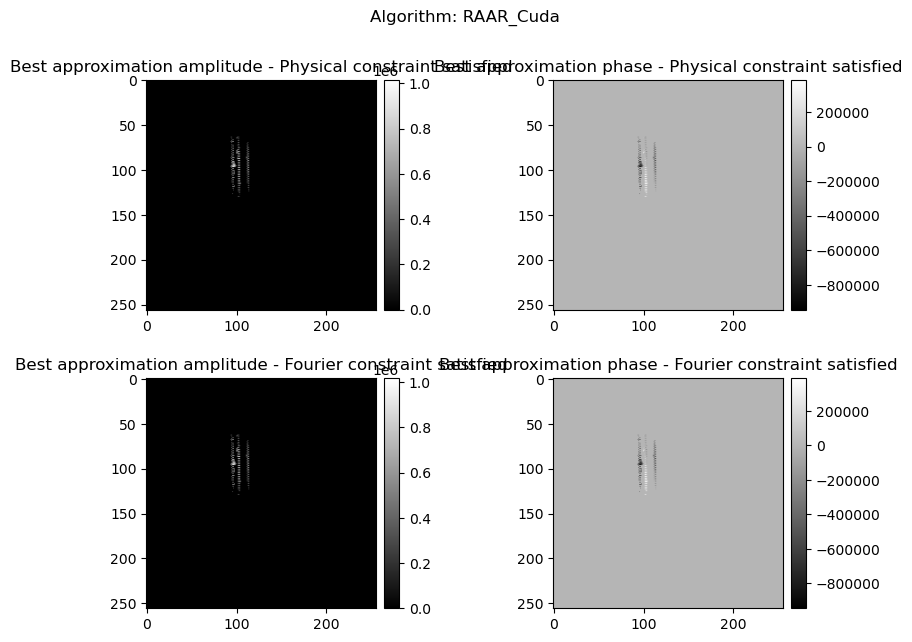

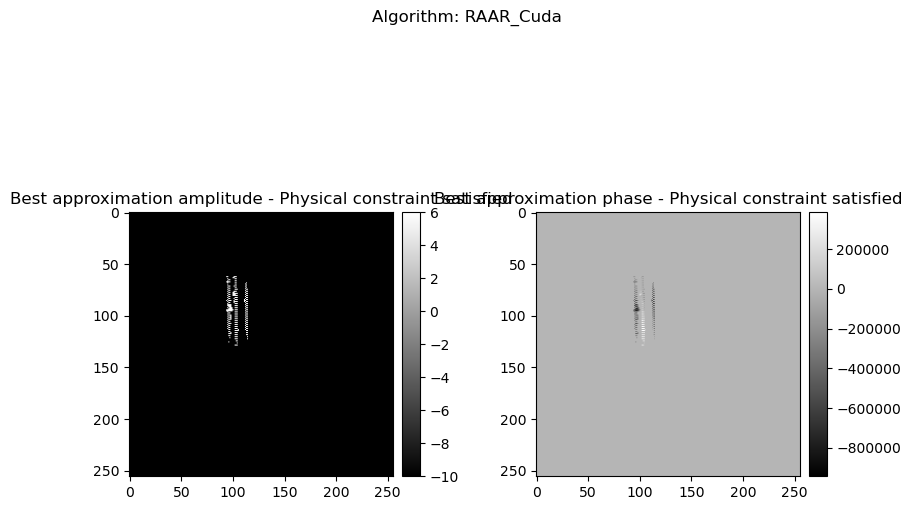

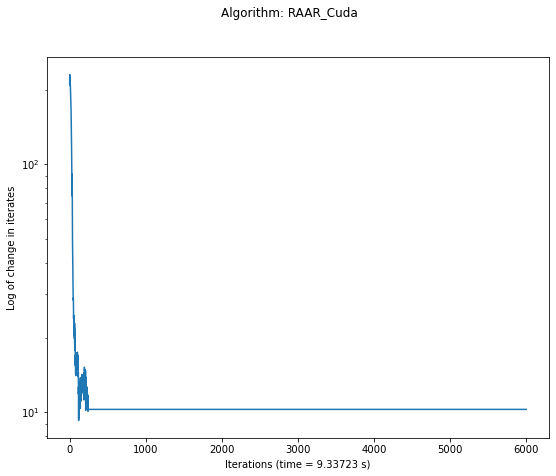

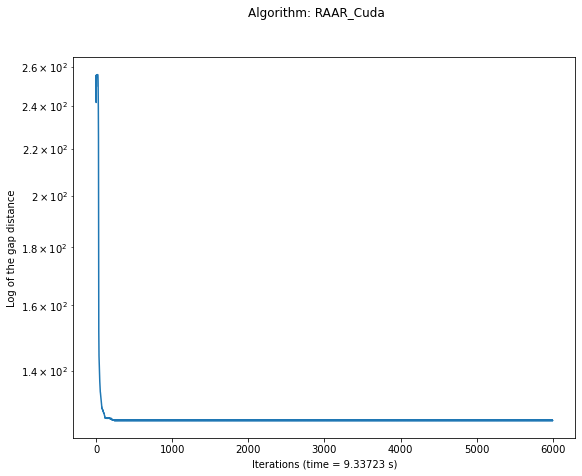

In [2]:
from proxtoolbox.experiments.phase.SIRIUS_CDI_Experiment_cuda import SIRIUS_CDI_Experiment_Cuda
CDI = SIRIUS_CDI_Experiment_Cuda(algorithm='RAAR_Cuda', Nx=256, Ny=256,
lambda_0=0.9, lambda_max=0.5)
CDI.run()
CDI.show()

### Multires experiment

Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 2.81516695022583 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 2.9948253631591797 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 690 iterations and 1.0495860576629639 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 3.1682450771331787 seconds.


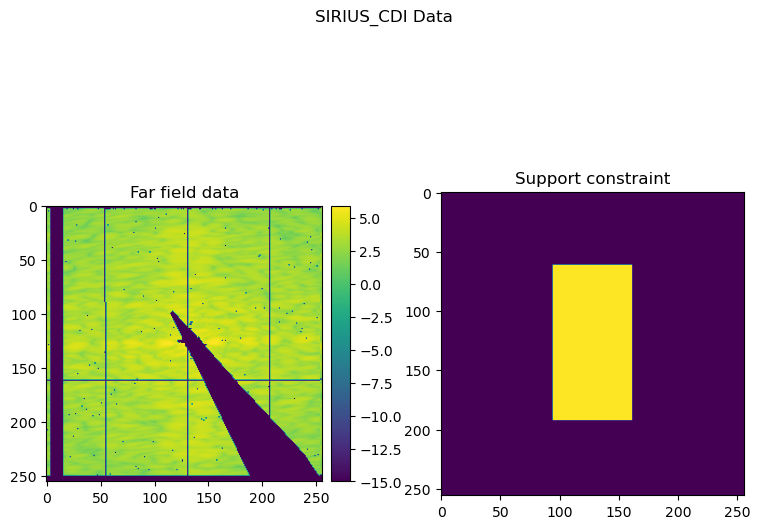

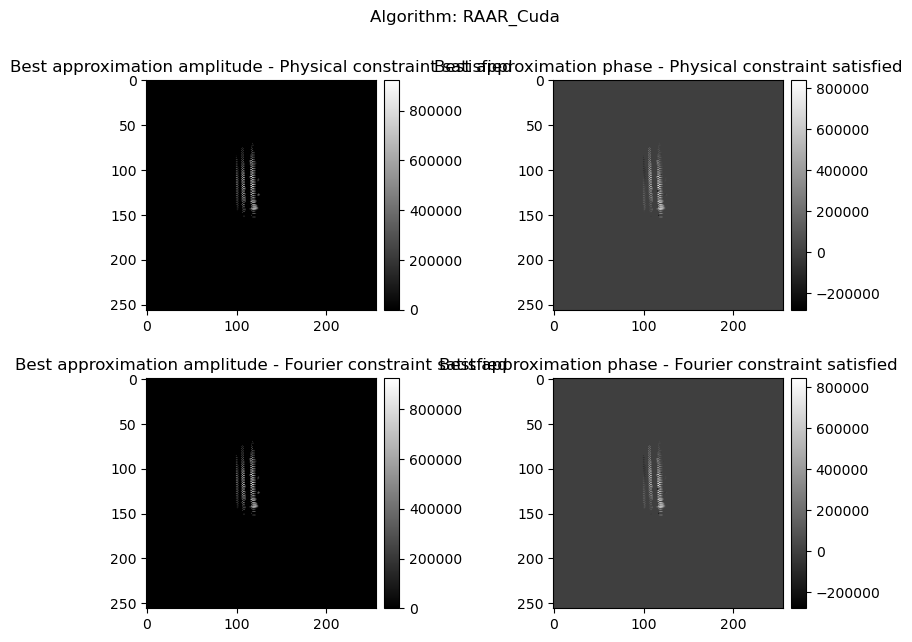

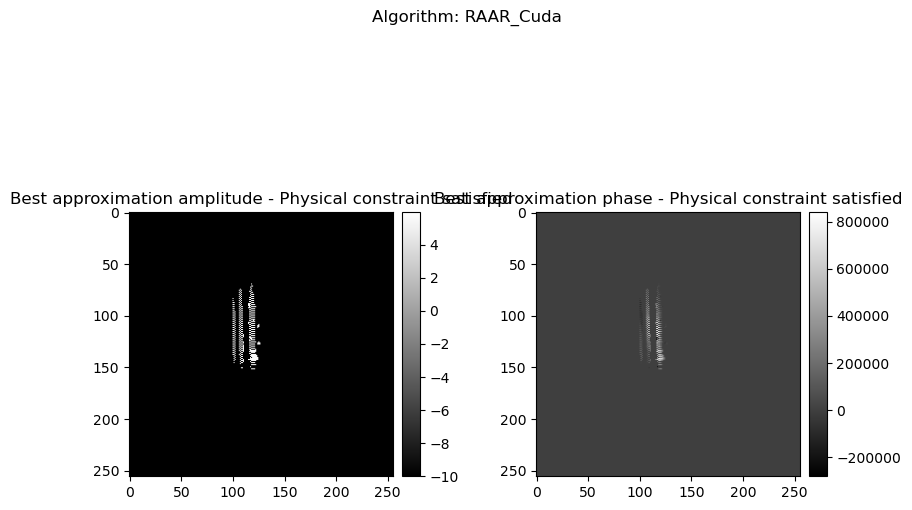

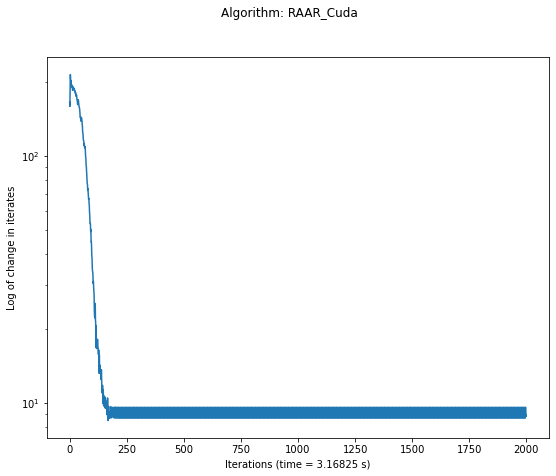

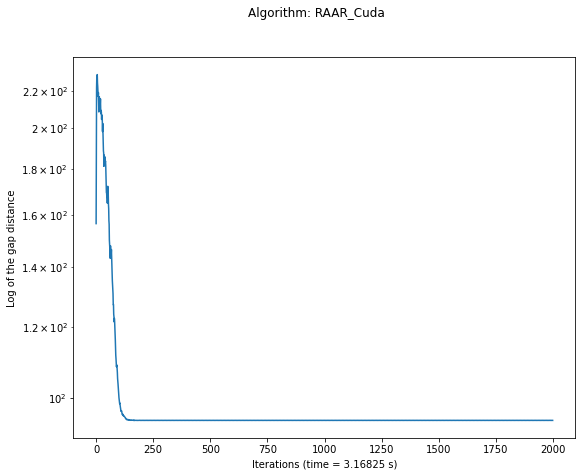

In [3]:
CDI_multires= None
for j in range(5,9):
    if CDI_multires==None:
        CDI_multires = SIRIUS_CDI_Experiment_Cuda(algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.7, lambda_switch=1000, lambda_max = 0.5, MAXIT=2000, TOL=5e-8, sparsity_parameter=8000)
    else:
        CDI_multires = SIRIUS_CDI_Experiment_Cuda(initial_guess = CDI_multires.output['u'], algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.9, lambda_max = 0.5, lambda_switch=100, MAXIT=2000, TOL=5e-5, sparsity_parameter=500)
    CDI_multires.run()
CDI_multires.show()

In [4]:
!nvidia-smi 

Sat Sep 14 22:15:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4500               Off | 00000000:01:00.0 Off |                  Off |
| 30%   39C    P2              55W / 200W |    368MiB / 20470MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### As we can see, the GPU was loaded properly


## 5. Performance Comparison

To compare the performance of the CPU and GPU implementations, you can run both versions and measure the execution time:


In [10]:
import time
from proxtoolbox.experiments.phase.SIRIUS_CDI_Experiment import SIRIUS_CDI_Experiment
from proxtoolbox.experiments.phase.SIRIUS_CDI_Experiment_cuda import SIRIUS_CDI_Experiment_Cuda

# CPU version (regular)

In [12]:
CDI_cpu = SIRIUS_CDI_Experiment(algorithm='DRl', Nx=256, Ny=256, lambda_0=0.9, lambda_max=0.5)
CDI_cpu.run()
cpu_time = CDI_cpu.output['stats']['time']

Loading data file diff2D_2_2796_2796
Using farfield formula.
Running DRl on SIRIUS_CDI...
Took 6000 iterations and 55.631425619125366 seconds.


# GPU version (regular)


In [13]:
CDI_gpu = SIRIUS_CDI_Experiment_Cuda(algorithm='RAAR_Cuda', Nx=256, Ny=256, lambda_0=0.9, lambda_max=0.5)
CDI_gpu.run()
gpu_time = CDI_gpu.output['stats']['time']

Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 6000 iterations and 9.435349225997925 seconds.


In [14]:
print(f"CPU execution time (regular): {cpu_time:.2f} seconds")
print(f"GPU execution time (regular): {gpu_time:.2f} seconds")
print(f"Speedup (regular): {cpu_time / gpu_time:.2f}x")

CPU execution time (regular): 55.63 seconds
GPU execution time (regular): 9.44 seconds
Speedup (regular): 5.90x


# CPU version (multires)

In [15]:
start_time = time.time()
CDI_multires_cpu= None
for j in range(5,9):
    if CDI_multires_cpu==None:
        CDI_multires_cpu = SIRIUS_CDI_Experiment(algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.7, lambda_switch=1000, lambda_max = 0.5, MAXIT=2000, TOL=5e-8, sparsity_parameter=8000)
    else:
        CDI_multires_cpu = SIRIUS_CDI_Experiment(initial_guess = CDI_multires_cpu.output['u'], algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.9, lambda_max = 0.5, lambda_switch=100, MAXIT=2000, TOL=5e-5, sparsity_parameter=500)
    CDI_multires_cpu.run()
# CDI_multires_cpu.show()
cpu_time = time.time() - start_time

Loading data file diff2D_2_2796_2796
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 0.42482495307922363 seconds.
Loading data file diff2D_2_2796_2796
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 1.0026013851165771 seconds.
Loading data file diff2D_2_2796_2796
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 731 iterations and 1.3249807357788086 seconds.
Loading data file diff2D_2_2796_2796
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 19.27917218208313 seconds.


# GPU version (multires)

In [16]:
start_time = time.time()
CDI_multires_gpu= None
for j in range(5,9):
    if CDI_multires_gpu==None:
        CDI_multires_gpu = SIRIUS_CDI_Experiment_Cuda(algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.7, lambda_switch=1000, lambda_max = 0.5, MAXIT=2000, TOL=5e-8, sparsity_parameter=8000)
    else:
        CDI_multires_gpu = SIRIUS_CDI_Experiment_Cuda(initial_guess = CDI_multires_gpu.output['u'], algorithm = 'RAAR_Cuda', Nx = 2**j, Ny = 2**j, 
            lambda_0 = 0.9, lambda_max = 0.5, lambda_switch=100, MAXIT=2000, TOL=5e-5, sparsity_parameter=500)
    CDI_multires_gpu.run()
# CDI_multires_gpu.show()
gpu_time = time.time() - start_time

Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 2.8130791187286377 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 2.996403694152832 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 3.0467004776000977 seconds.
Using farfield formula.
Running RAAR_Cuda on SIRIUS_CDI...
Took 2000 iterations and 3.1181929111480713 seconds.


### For the multires experiment, the parallelization should affect the last stage of the experiment, not the warmup steps since it would take longer to initialize data for a small scale experiment with a GPU. Thus, we can see that the overall time of experiment on the GPU exeeds the CPU time.

In [18]:
print(f"CPU execution time (multires): {cpu_time:.2f} seconds")
print(f"GPU execution time (multires): {gpu_time:.2f} seconds")
print(f"Speedup (multires): {cpu_time / gpu_time:.2f}x")

CPU execution time (multires): 22.11 seconds
GPU execution time (multires): 12.12 seconds
Speedup (multires): 1.82x


### However, to properly assess the result we need to focus on the last stage (the main one). Extracting the time from the logs we get the expected speedup:

In [19]:
cpu_time_last = 19.27917218208313
gpu_time_last = 3.1181929111480713
print(f"CPU execution time (multires): {cpu_time_last:.2f} seconds")
print(f"GPU execution time (multires): {gpu_time_last:.2f} seconds")
print(f"Speedup (multires): {cpu_time_last / gpu_time_last:.2f}x")

CPU execution time (multires): 19.28 seconds
GPU execution time (multires): 3.12 seconds
Speedup (multires): 6.18x


## 7. Profile

To determine bottlenecks we used cProfile

```python3 -m cProfile -o output.pstats demos/SIRIUS_drl_cuda.py```


and used pyprof2html for a table and gprof2dot to create a flowchart. You can find those in the profie folder.

```
pyprof2html output.pstats
gprof2dot -f pstats output.pstats | dot - Tpng -o output.png
```

![title](profile/output.png)


## 7. Conclusion

By parallelizing the RAAR algorithm and the SIRIUS CDI experiment using CUDA, we've achieved significant speedup in execution time. This allows for faster processing of larger datasets and more iterations, potentially improving the quality of phase retrieval results.